In [152]:
import numpy as np
import pandas as pd
import time
import random
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.patches as mpatches


In [ ]:
def plot_scores(scores, details, x_values, x_label):
    marks = ['r-', 'b-', 'y-']

    plt.figure(figsize=(16,9))

    plt.legend(handles=[mpatches.Patch(color='red', label=details[0]),
                       mpatches.Patch(color='yellow', label=details[1]),
                       mpatches.Patch(color='blue', label=details[2])])

    for score, mark in zip(scores, marks):  
        plt.plot(score, mark)

    plt.ylabel("Success rate")
    plt.xlabel(x_label)
    x_lables = list(x_values[0::np.round(len(x_values)/10).astype(int)])
    x_lables.append(x_values[len(x_values)-1])
    plt.ylim(0.5,1)
    plt.xticks(np.append(np.arange(0, len(x_values),len(x_values)/10).astype(int), [len(x_values)]), x_lables)
    
    plt.show()

In [153]:
trainDataFilePath = "ExcerciseData\\real_project_data.xls";
# Read the data
print("Reading the data from the xls file")

xl = pd.ExcelFile(trainDataFilePath)


parsed = xl.parse(xl.sheet_names[0])
data = np.array(parsed)

rows, cols = data.shape

# Classification is in the last column
Y = data[:, cols - 1]
X = data[:, :cols - 1]

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=.4, random_state=42)

Reading the data from the xls file


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [187]:
C_arr = np.arange(0.001, 5, 0.05)
svm_kernels = ["linear", "rbf", "sigmoid"]
kernels_score = []
for ker in svm_kernels:
    ker_score = []
    for c in C_arr:
        clf = SVC(kernel=ker, C=c, degree=2)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        ker_score.append(score)
    kernels_score.append(ker_score)

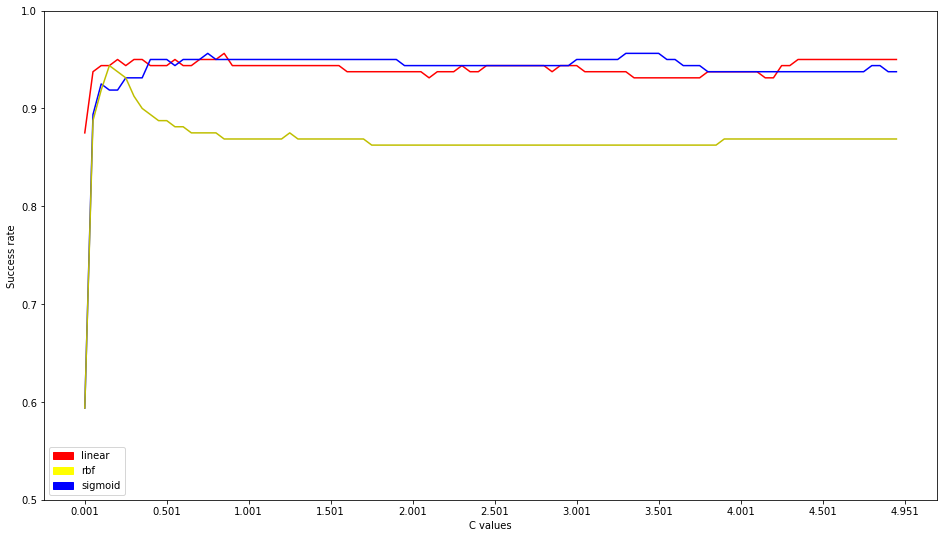

In [188]:
plot_scores(kernels_score,svm_kernels,C_arr, "C values" )

In [215]:
from LogisticRegression.LogisticRegression import LogisticRegression

def summarize_model(model, train_x, train_y, test_x, test_y):
    train_prediction = model.predict(train_x)
    train_errors = float(sum(train_prediction != train_y)) / len(train_y)

    test_prediction = model.predict(test_x)
    test_errors = float(sum(test_prediction != test_y)) / len(test_y)

    return train_errors, test_errors

def run_logistic_regression(X_train, y_train, X_test, y_test, alpha, num_of_features):
    zero_one_y_train = [0 if c == 'M' else 1 for c in y_train]

    zero_one_y_test = [0 if c == 'M' else 1 for c in y_test]

    start = time.time()
    model = LogisticRegression(X_train, zero_one_y_train, alpha, num_of_features)
    iterations_cost_array = model.gradient_decent(500, 0.01)
    #print("time for BGD train:", time.time() - start)

    #print("last cost:", iterations_cost_array[len(iterations_cost_array) - 1])

    train_errors, test_errors = summarize_model(model, X_train, zero_one_y_train, X_test, zero_one_y_test)
    #print("Using BGD: train Err=", train_errors, "test Err=", test_errors, '\n')

    return 1-test_errors

In [218]:
alpha_arr = np.arange(0.05, 5, 0.05)
num_of_features = [5,10,15]
features_detailes = ["5 features", "10 features", "15 features"]
scores = []
for nf in num_of_features:
    score = []
    for a in alpha_arr:
        s = run_logistic_regression(X_train, y_train, X_test, y_test, a, nf)
        score.append(s)
    scores.append(score)

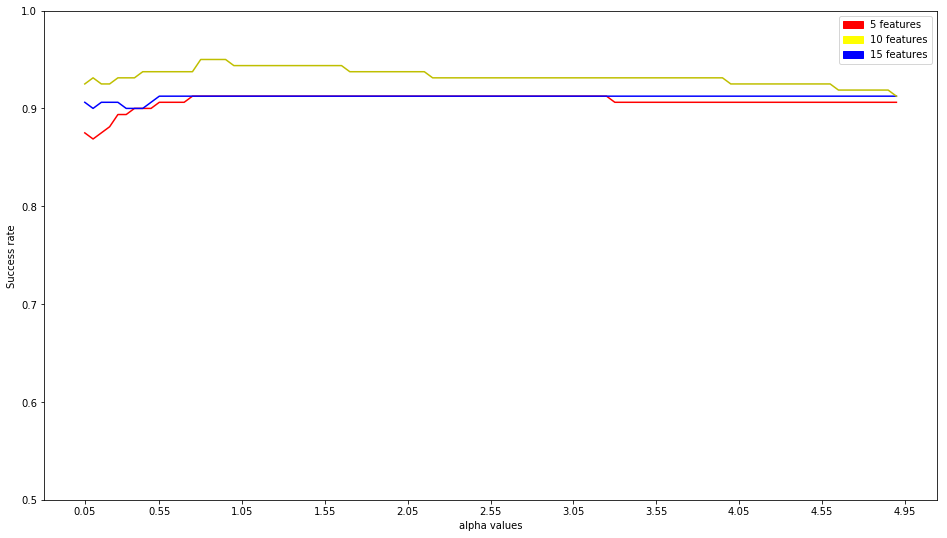

In [219]:
plot_scores(scores,features_detailes,alpha_arr, "alpha values" )

In [220]:
def run_logistic_regression(X_train, y_train, X_test, y_test, alpha, num_of_features):
    zero_one_y_train = [0 if c == 'M' else 1 for c in y_train]

    zero_one_y_test = [0 if c == 'M' else 1 for c in y_test]

    start = time.time()
    model = LogisticRegression(X_train, zero_one_y_train, alpha, num_of_features)
    iterations_cost_array = model.stochastic_gradient_decent(500, 0.01)
    #print("time for BGD train:", time.time() - start)

    #print("last cost:", iterations_cost_array[len(iterations_cost_array) - 1])

    train_errors, test_errors = summarize_model(model, X_train, zero_one_y_train, X_test, zero_one_y_test)
    #print("Using BGD: train Err=", train_errors, "test Err=", test_errors, '\n')

    return 1-test_errors

In [221]:
alpha_arr = np.arange(0.05, 5, 0.05)
num_of_features = [5,10,15]
features_detailes = ["5 features", "10 features", "15 features"]
scores = []
for nf in num_of_features:
    score = []
    for a in alpha_arr:
        s = run_logistic_regression(X_train, y_train, X_test, y_test, a, nf)
        score.append(s)
    scores.append(score)

C:\Users\JERLocal\Documents\MachineLearningAlgorithmsComparison\LogisticRegression\LogisticRegression.py:93: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + numpy.exp(-z))
C:\Users\JERLocal\Documents\MachineLearningAlgorithmsComparison\LogisticRegression\LogisticRegression.py:112: RuntimeWarning: divide by zero encountered in log
  prob_y_1 = -1 * self.Y * numpy.log(h_theta)
C:\Users\JERLocal\Documents\MachineLearningAlgorithmsComparison\LogisticRegression\LogisticRegression.py:112: RuntimeWarning: invalid value encountered in multiply
  prob_y_1 = -1 * self.Y * numpy.log(h_theta)


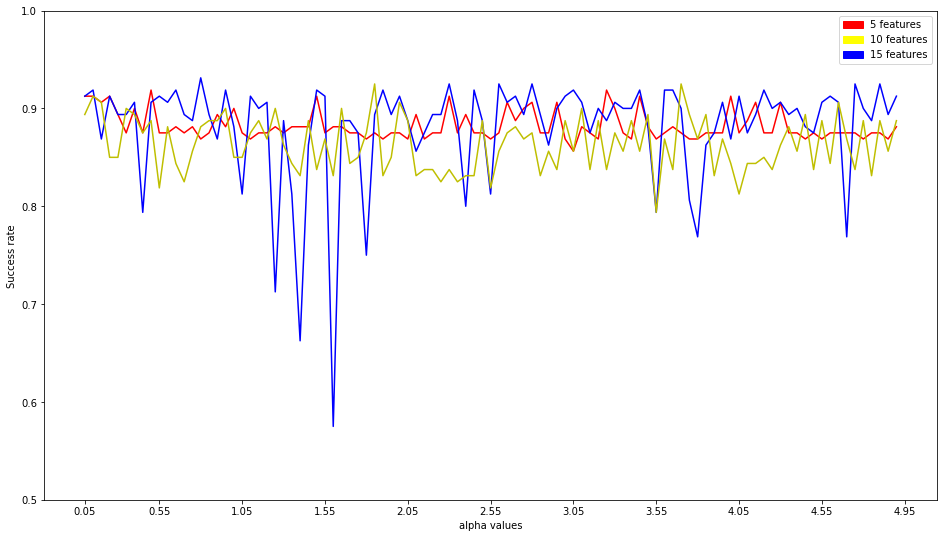

In [222]:
plot_scores(scores,features_detailes,alpha_arr, "alpha values" )